Figure 2B

By Harshaan Sekhon (sskhon2014@berkeley.edu)

The code below takes as input two datasets and produces a bar-chart depicting the abundance of various RNA-binding protein domain motifs within a dataset of RNA abundance within Jurkat T Cells.

The two resources that this code relies upon are as follows:
    
1. **JSL_stim_unstim_exp.csv**: Processed RNA-Seq read counts provided by the following: Felce J: RNA-Seq analysis of early transcriptional responses to activation in the leukaemic Jurkat E6.1 T cell line. 2020b. http://www.doi.org/10.17605/OSF.IO/7X8CG as linked to by Felce et. al (https://wellcomeopenresearch.org/articles/5-42#ref-8) (GSE145453 2x resting and 2x stimulated Jurkat E6.1 cells). Ensembl ID (Release 102) column was then mapped to Entrez Gene ID using the python module pyensembl. pyensembl was installed with the following terminal commands: <code>pip install pyensembl</code> && <code>pyensembl install --release 102 --species human</code>


2. **RBPDB_v1.3.1_proteins_2012-11-21.tdt.txt**: a catalog of RNA-binding protein domain instances within the human genome, sourced from http://rbpdb.ccbr.utoronto.ca/download.php (Specific link:http://rbpdb.ccbr.utoronto.ca/downloads/RBPDB_v1.3.1_proteins_2012-11-21.tdt).


In [1]:
import numpy as np
from datascience import *
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
RNA_exp = Table().read_table("Resources/JSL_stim_unstim_exp.csv")
RNA_exp = RNA_exp.with_column("geneid", [i.upper() for i in RNA_exp.column("geneid")])

RNA_exp = RNA_exp.with_column("reads", RNA_exp.column("resting1") + RNA_exp.column("resting2") + RNA_exp.column("stim1")+ RNA_exp.column("stim2")).select('Gene', 'geneid','reads')
RNA_exp

Gene,geneid,reads
ENSG00000223972,DDX11L1,1
ENSG00000227232,WASH7P,708
ENSG00000243485,MIR1302-2HG,0
ENSG00000237613,FAM138A,0
ENSG00000268020,OR4G4P,0
ENSG00000240361,OR4G11P,0
ENSG00000186092,OR4F5,0
ENSG00000238009,AL627309.1,8
ENSG00000239945,AL627309.3,0
ENSG00000233750,CICP27,3


In [3]:
file1 = open('Resources/RBPDB_v1.3.1_proteins_2012-11-21.tdt.txt', 'r')
Lines = file1.readlines()
Lines = np.asarray([i.split('\t') for i in Lines])

In [4]:
prot_domains = Table().with_columns('emsembl_id',Lines.T[1], 'geneid', Lines.T[4], 'species', Lines.T[6], 'domains', Lines.T[8])

In [5]:
prot_domains = prot_domains.where('species', are.equal_to("Homo sapiens")).where('domains', are.not_equal_to("\\N")).where('domains', are.not_equal_to(""))
prot_domains

emsembl_id,geneid,species,domains
ENSG00000003756,RBM5,Homo sapiens,RRMx2; Znf_C2H2x1
ENSG00000004139,SARM1,Homo sapiens,SAMx1
ENSG00000004534,RBM6,Homo sapiens,RRMx2
ENSG00000005189,,Homo sapiens,RRMx2
ENSG00000006047,YBX2,Homo sapiens,CSDx1
ENSG00000009307,CSDE1,Homo sapiens,CSDx5
ENSG00000011304,PTBP1,Homo sapiens,RRMx4
ENSG00000014164,ZC3H3,Homo sapiens,Znf_CCCHx1
ENSG00000015479,MATR3,Homo sapiens,RRMx2
ENSG00000020577,SAMD4A,Homo sapiens,SAMx1


In [6]:
prot_combo = RNA_exp.join("geneid", prot_domains).select("domains", "reads")
prot_combo

domains,reads
RRMx3,0
Znf_CCCHx1,3
RRMx1,32826
KHx1,8113
RRMx1,2529
KHx1,481
KHx1,15416
KHx1,4241
Znfx1; SAMx1,6332
KHx3; SAMx1,98


In [7]:
abundance_list= []
domain_list = []

for i in np.arange(prot_combo.num_rows):
    domains = prot_combo["domains"][i].split("; ")
    read_count = float(prot_combo["reads"][i])
    
    for domain in domains:
        if 'x' in domain:
            domain = domain[:domain.find("x")]
        domain_list.append(domain)
        abundance_list.append(read_count)

In [8]:
summary = Table().with_columns("domainZ", domain_list,"reads" , abundance_list).group(0, sum).sort(1, descending=True)
summary

domainZ,reads sum
RRM,2.96805e+06
KH,455805
Znf_CCCH,336215
CSD,220507
LSm,166126
Znf_RanBP2,156189
Znf_CHHC,132396
Znf_C2H2,89072
S1,88848
La,80740


In [9]:
summary.to_csv("Jurkat_E6.1_Data--RBPDB v1.3.csv")

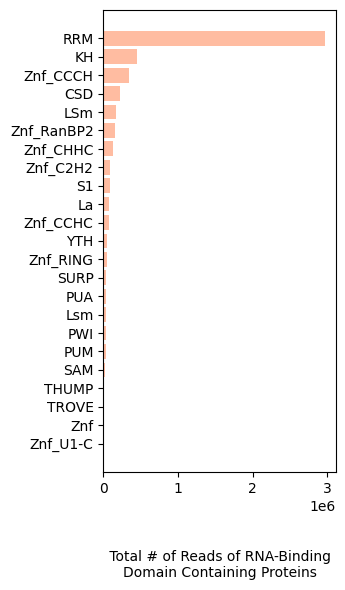

In [10]:
import matplotlib.pyplot as plt
import numpy as np


plt.rcdefaults()
fig, ax = plt.subplots(figsize=(3,6))

ax.barh(np.arange(len(summary.column(0))), summary.column(1), align='center', color="lightsalmon", alpha=0.7)
ax.set_yticks(np.arange(len(summary.column(0))))
ax.set_yticklabels(summary.column(0))
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('\n\n\n Total # of Reads of RNA-Binding \nDomain Containing Proteins')

plt.savefig("Domain-Abundance-Chart.pdf",bbox_inches = "tight")